In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions


from salishsea_tools.nc_tools import scDataset

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from matplotlib import animation

from matplotlib.ticker import MultipleLocator

In [2]:
def get_files(dirname, fname, grid):
    files = []    
    for item in os.listdir(dirname):
        if fnmatch.fnmatchcase(item, fname + grid + "*.nc"):
            files += [os.path.join(dirname, item)]
    files.sort(key=os.path.basename)
    return files

In [3]:
def U_timeseries(dirname, fname, x_start, x_end, y_start, y_end):
    
    filesU = get_files(dirname, fname, 'grid_U')        
    filesV = get_files(dirname, fname, 'grid_V')
    
    y = slice(y_start, y_end, None)
    x = slice(x_start, x_end, None)

    with scDataset(filesU) as dsU, scDataset(filesV) as dsV:
        vozocrtx0 = dsU.variables['vozocrtx'][:,:,y,x]
        print('U')
        vomecrty0 = dsV.variables['vomecrty'][:,:,y,x]
        print('V')
        sozotaux = dsU.variables['sozotaux'][:,0,0]
        sometauy = dsV.variables['sometauy'][:,0,0]
        depthu = dsU.variables['depthu'][:]

    with nc.Dataset(os.path.join(dirname, '1_mesh_mask.nc'), 'r') as dsM:
        umask0 = dsM.variables['umask'][0,:,y,x]
        vmask0 = dsM.variables['vmask'][0,:,y,x]

    umask = np.tile(umask0, (len(sozotaux),1, 1, 1))
    vmask = np.tile(vmask0, (len(sozotaux),1, 1, 1))

    vozocrtx = np.ma.array(vozocrtx0, mask=1 - umask)
    vomecrty = np.ma.array(vomecrty0, mask=1 - vmask)
    
    return vozocrtx, vomecrty, umask, vmask, depthu

In [4]:
def get_speeds(U_vel, V_vel, dep, time_ind, arrow):
    '''This function unstaggers the velocity components
    and calculates the speeds at arrow intervals.
    
    #from /ocean/imachuca/Canyons/mackenzie_canyon/tools/functions_velocity.py
    '''
    ugrid = U_vel[time_ind, dep, :, :]
    vgrid = V_vel[time_ind, dep, :, :]
    u_nstg0 = (np.add(ugrid[..., :-1], ugrid[..., 1:]) / 2)[..., 1:, :]
    v_nstg0 = (np.add(vgrid[..., :-1, :], vgrid[..., 1:, :]) / 2)[..., 1:]
    u_nstg = u_nstg0[::arrow,::arrow]
    v_nstg = v_nstg0[::arrow,::arrow]
    x_slice = np.arange(1, ugrid.shape[1])[::arrow]
    y_slice = np.arange(1, ugrid.shape[0])[::arrow]
    speeds = np.sqrt(u_nstg**2 + v_nstg**2)
    return speeds

## Parent bathymetry

In [5]:
bfile = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/NEMO_files/idealized/ideal_bathy_for_agrif.nc')
bathy = bfile['Bathymetry'][:]
xsb = np.arange(bathy.shape[-1])
ysb = np.arange(bathy.shape[-2])

## Complete masks

In [6]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/idealized/sbcana_forcings/agrif_wind_timestep/'
with nc.Dataset(os.path.join(dirname, '1_mesh_mask.nc'), 'r') as dsM:
    umask_all = dsM.variables['umask'][0,:,:,:]
    vmask_all = dsM.variables['vmask'][0,:,:,:]

## Incoming velocity time series

In [7]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/idealized/sbcana_forcings/agrif_wind_timestep/'
fname = "1_MCKNZ_1h_20170101_20170120_*"

In [65]:
x_start = 130
x_end = 200
y_start = 45
y_end = 180

x_axis=110

In [43]:
vozocrtx, vomecrty, umask, vmask, depthu = U_timeseries(dirname, fname, x_start, x_end, y_start, y_end)

U
V


## Child masks at depths

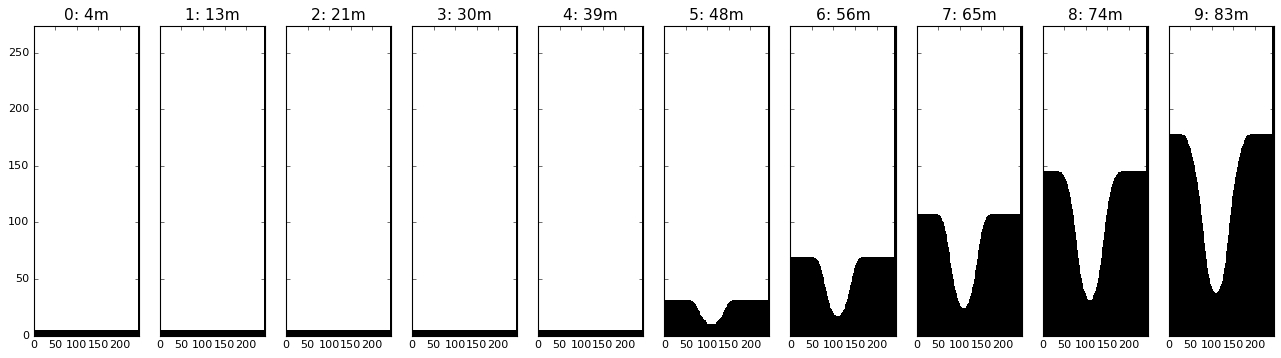

In [44]:
fig, axes = plt.subplots(1, 10, figsize=(20,5), sharey=True)
for ax, n in zip(axes.flatten(), np.arange(10)):
    ax.pcolormesh(umask_all[n, :,:], cmap=cm.binary_r)
    ax.set_ylim([0, umask_all.shape[-2]])
    ax.set_xlim([0, umask_all.shape[-1]])
    ax.set_title(str(n) + ': ' + str(int(depthu[n])) + 'm', fontsize=14)

## Positioning of incoming velocity region

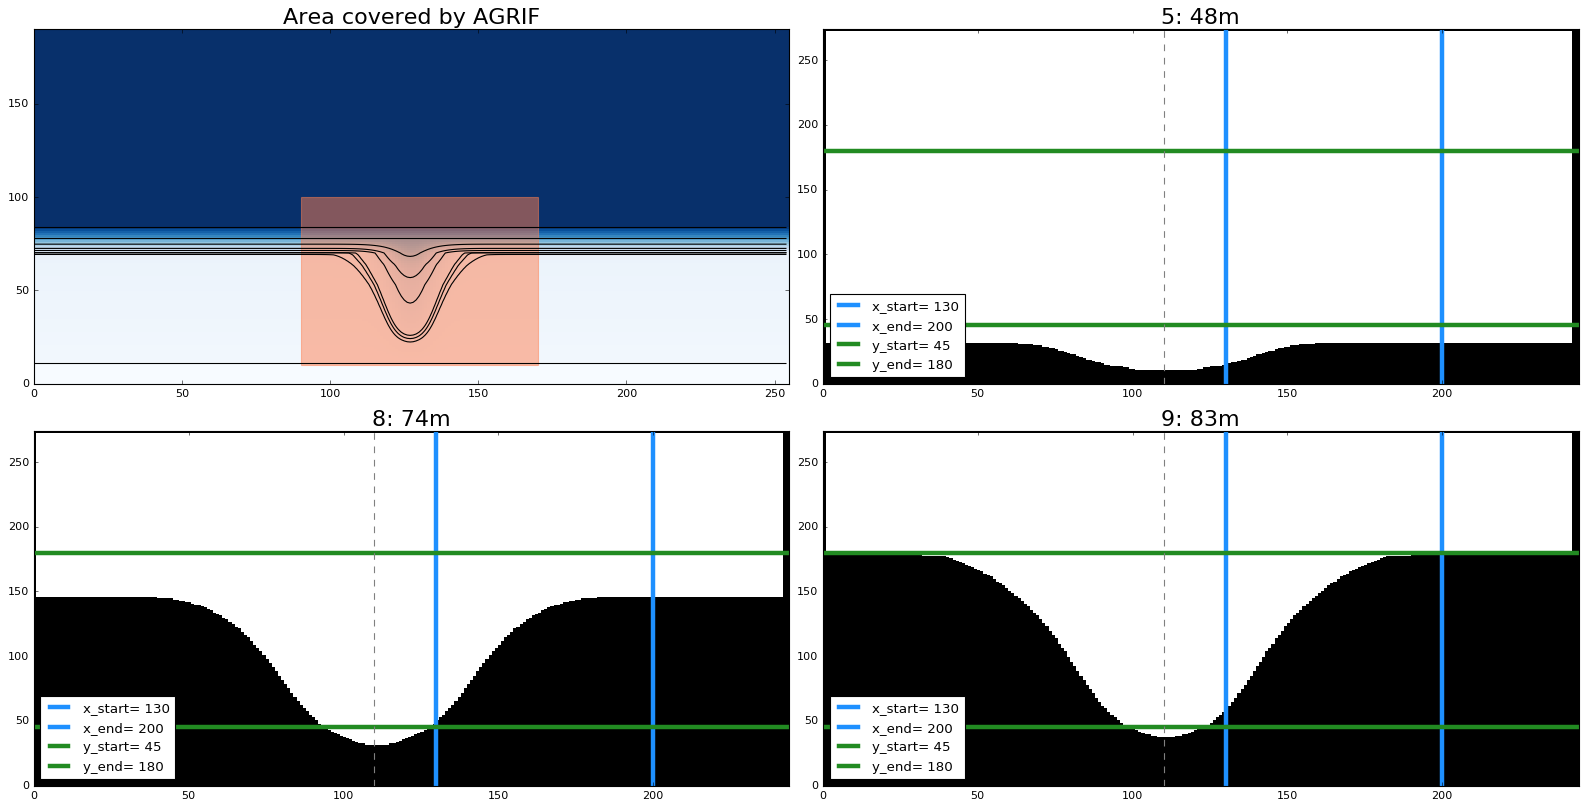

In [66]:
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2, figsize=(20, 10))
fig.tight_layout(w_pad=0.2, h_pad=2.5)

ax1.contour(xsb, ysb, bathy, levels = [0,80,90,100,200,300,500,800,1299],colors='k')
ax1.pcolormesh(bathy, cmap=cm.Blues)
ax1.add_patch(patches.Rectangle((90, 10),80,90, color='coral', alpha=0.5)) #90 170 10 100
ax1.set_title('Area covered by AGRIF', fontsize=20)

lw=4
for dep_ind, ax, n in zip([5, 8, 9], [ax2, ax3, ax4], np.arange(3)):
    ax.pcolormesh(umask_all[dep_ind, :,:], cmap=cm.binary_r)
    ax.set_ylim([0, umask_all.shape[-2]])
    ax.set_xlim([0, umask_all.shape[-1]])
    ax.set_title(str(dep_ind) + ': ' + str(int(depthu[dep_ind])) + 'm', fontsize=20)
    ax.axvline(x_start, c='dodgerblue', linewidth=lw, label='x_start= '+str(x_start))
    ax.axvline(x_end, c='dodgerblue', linewidth=lw, label='x_end= '+str(x_end))
    ax.axhline(y_start, c='forestgreen', linewidth=lw, label='y_start= '+str(y_start))
    ax.axhline(y_end, c='forestgreen', linewidth=lw, label='y_end= '+str(y_end))
    ax.legend(loc=3)
    ax.axvline(x_axis, c='gray', linestyle='--')

## Finding average U, V, speeds

In [46]:
speeds_all = np.ones([480, 80, y_end-y_start-1, x_end-x_start-1])

for dep_ind in np.arange(80):
    for time_ind in np.arange(480):
        speeds = get_speeds(vozocrtx, vomecrty, dep_ind, time_ind, 1)
        speeds_all[time_ind, dep_ind, :, :] = speeds

In [47]:
avgU = np.mean(np.mean(vozocrtx, axis=-1), axis=-1)
avgV = np.mean(np.mean(vomecrty, axis=-1), axis=-1)
avgS = np.mean(np.mean(speeds_all, axis=-1), axis=-1)

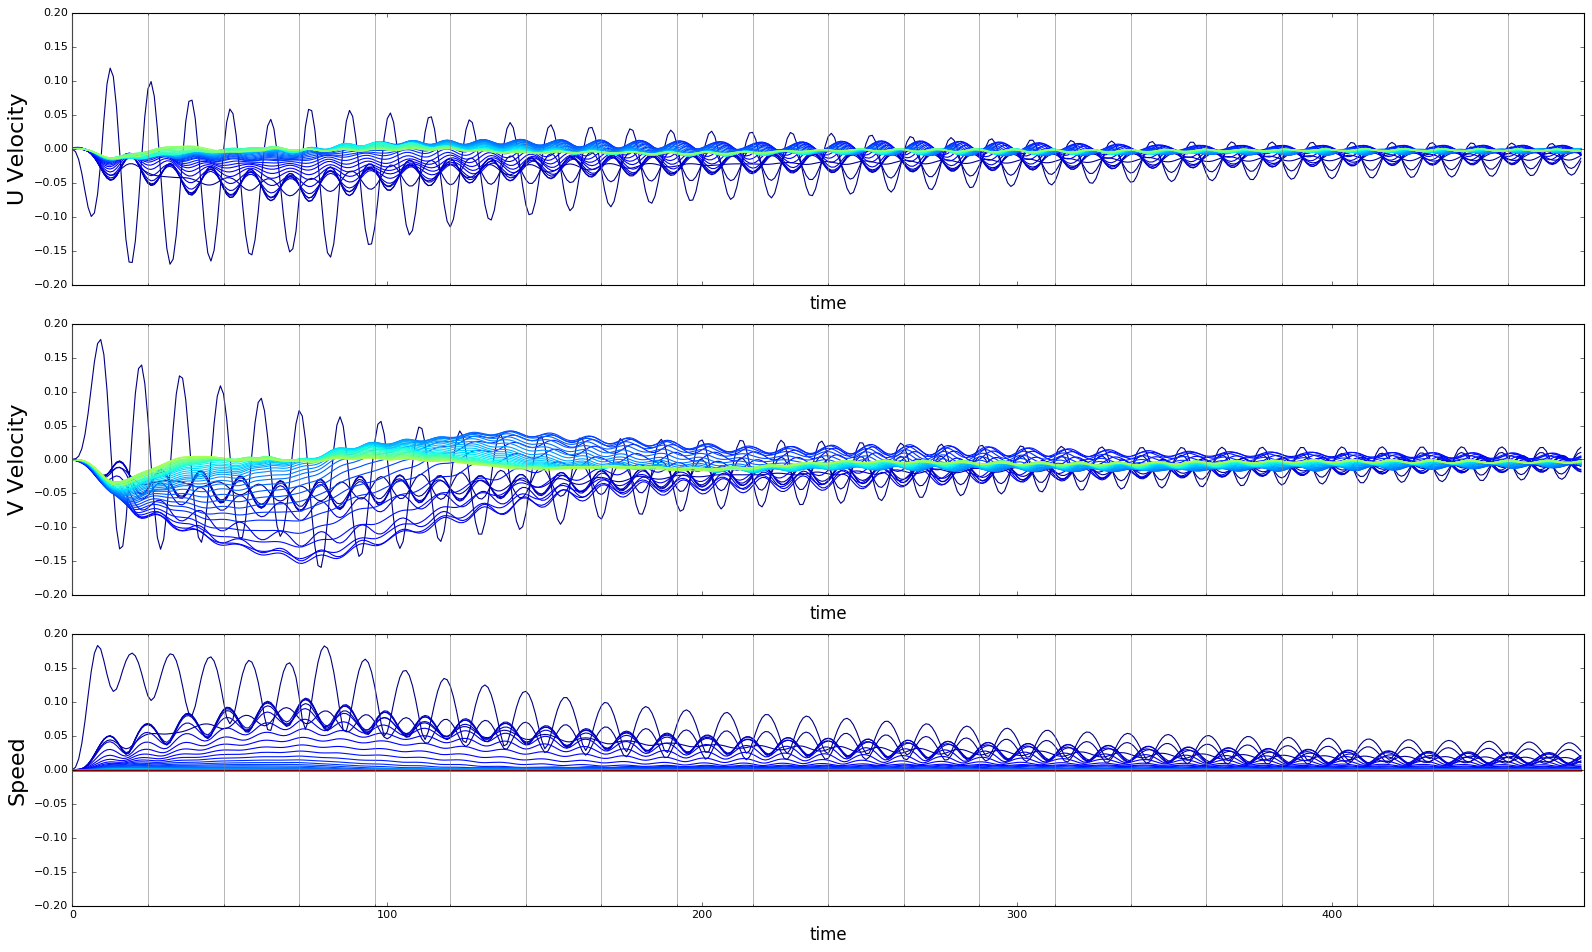

In [112]:
cm_times = np.linspace(0, 1, 80)
colors = [ cm.jet(x) for x in cm_times]

fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(20, 12), sharex=True)
for dep_ind, c in zip(np.arange(80), colors):
    ax1.plot(avgU[:, dep_ind], c=c)
    ax2.plot(avgV[:, dep_ind], c=c)
    ax3.plot(avgS[:, dep_ind], c=c)

for ax, ttl in zip([ax1, ax2, ax3], ['U Velocity','V Velocity','Speed']):
    ax.set_xlabel('time', fontsize=15)
    ax.set_ylabel(ttl, fontsize=20)
    ax.set_xlim([0, 480])
    ax.set_ylim([-0.2, 0.2])
    ml = MultipleLocator(24)
    ax.xaxis.set_minor_locator(ml)
    ax.xaxis.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
    
fig.tight_layout(h_pad=0.5)

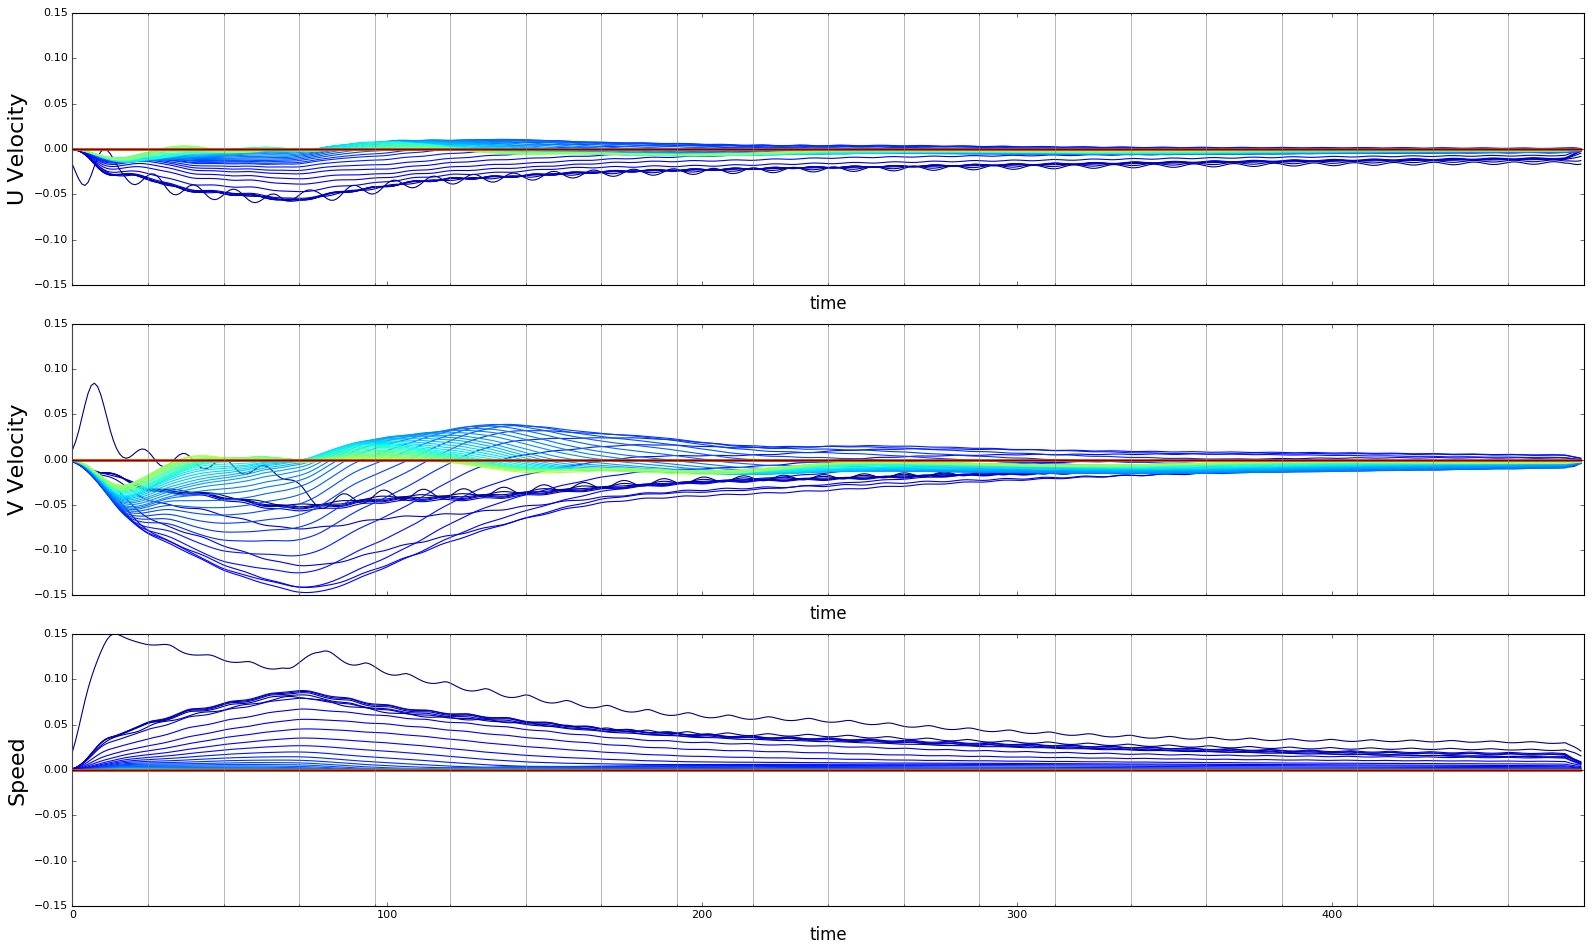

In [50]:
cm_times = np.linspace(0, 1, 80)
colors = [ cm.jet(x) for x in cm_times]

fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(20, 12), sharex=True)
for dep_ind, c in zip(np.arange(80), colors):
    ax1.plot(general_functions.smooth(avgU[:, dep_ind], 12), c=c)
    ax2.plot(general_functions.smooth(avgV[:, dep_ind], 12), c=c)
    ax3.plot(general_functions.smooth(avgS[:, dep_ind], 12), c=c)

for ax, ttl in zip([ax1, ax2, ax3], ['U Velocity','V Velocity','Speed']):
    ax.set_xlabel('time', fontsize=15)
    ax.set_ylabel(ttl, fontsize=20)
    ax.set_xlim([0, 480])
    ax.set_ylim([-0.15, 0.15])
    ml = MultipleLocator(24)
    ax.xaxis.set_minor_locator(ml)
    ax.xaxis.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
fig.tight_layout(h_pad=0.5)

## Depth profiles of U 

In [51]:
def U_profile(dirname, fname, time_ind):
    
    filesU = get_files(dirname, fname, 'grid_U')        
    filesV = get_files(dirname, fname, 'grid_V')
    
    y = slice(1, -1, None)
    x = slice(1, -1, None)

    with scDataset(filesU) as dsU, scDataset(filesV) as dsV:
        vozocrtx0 = dsU.variables['vozocrtx'][time_ind,:,y,x]
        sozotaux = dsU.variables['sozotaux'][:,0,0]

    with nc.Dataset(os.path.join(dirname, '1_mesh_mask.nc'), 'r') as dsM:
        umask = dsM.variables['umask'][0,:,y,x]

    vozocrtx = np.ma.array(vozocrtx0, mask=1 - umask)
    
    return vozocrtx

In [52]:
vozocrtx_day3 = U_profile(dirname, fname, 72)
vozocrtx_day4 = U_profile(dirname, fname, 96)
vozocrtx_day8 = U_profile(dirname, fname, 24*8)
vozocrtx_day15 = U_profile(dirname, fname, 24*15)

In [93]:
xs = np.arange(vozocrtx_day3.shape[-1])
ys = np.arange(vozocrtx_day3.shape[-2])
zs = np.arange(vozocrtx_day3.shape[-3])

dep_ind0, dep_ind1, dep_ind2, dep_ind3 = 0, 5, 8, 9

In [108]:
def plot_crossU(x_ind, vozocrtx_day3, vozocrtx_day4, vozocrtx_day8, vozocrtx_day15):
    fig, axes = plt.subplots(2,2,figsize=(20, 12), sharex=True, sharey=True)
    fig.tight_layout(h_pad=2, w_pad=0.2)
    cmap = plt.get_cmap(cmo.cm.balance)
    cmap.set_bad('wheat')
    vels = [vozocrtx_day3, vozocrtx_day4, vozocrtx_day8, vozocrtx_day15]
    ttls = ['day 3', 'day 4', 'day 8', 'day 12']
    for ax, vel, ttl, n in zip(axes.flatten(), vels, ttls, np.arange(4)):
        p = ax.pcolormesh(ys, zs, vel[:, :, x_ind], cmap=cmap, vmin=-0.15, vmax=0.15)
        ax.set_ylim([80, 0])
        ax.set_xlim([0, vel.shape[-2]])
        fig.colorbar(p, ax=ax)
        ax.set_title(ttl, fontsize=20)
        ax.add_patch(patches.Rectangle((y_start, dep_ind0),y_end-y_start, dep_ind3-dep_ind0, fill=False, linewidth=3))
    return fig

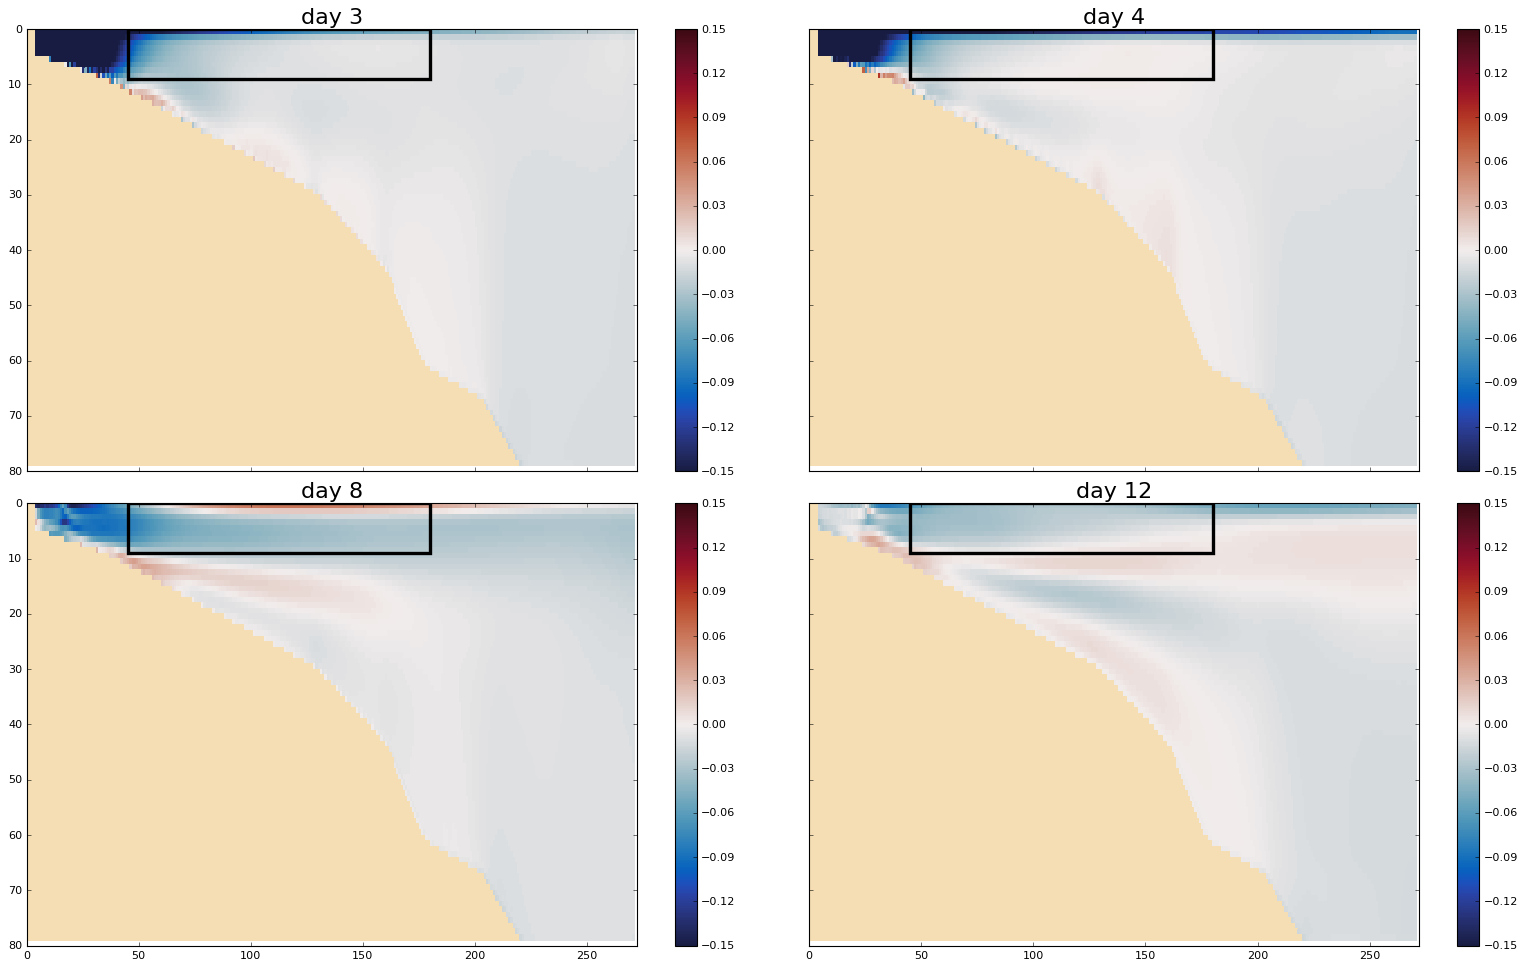

In [109]:
fig = plot_crossU(x_axis, vozocrtx_day3, vozocrtx_day4, vozocrtx_day8, vozocrtx_day15)

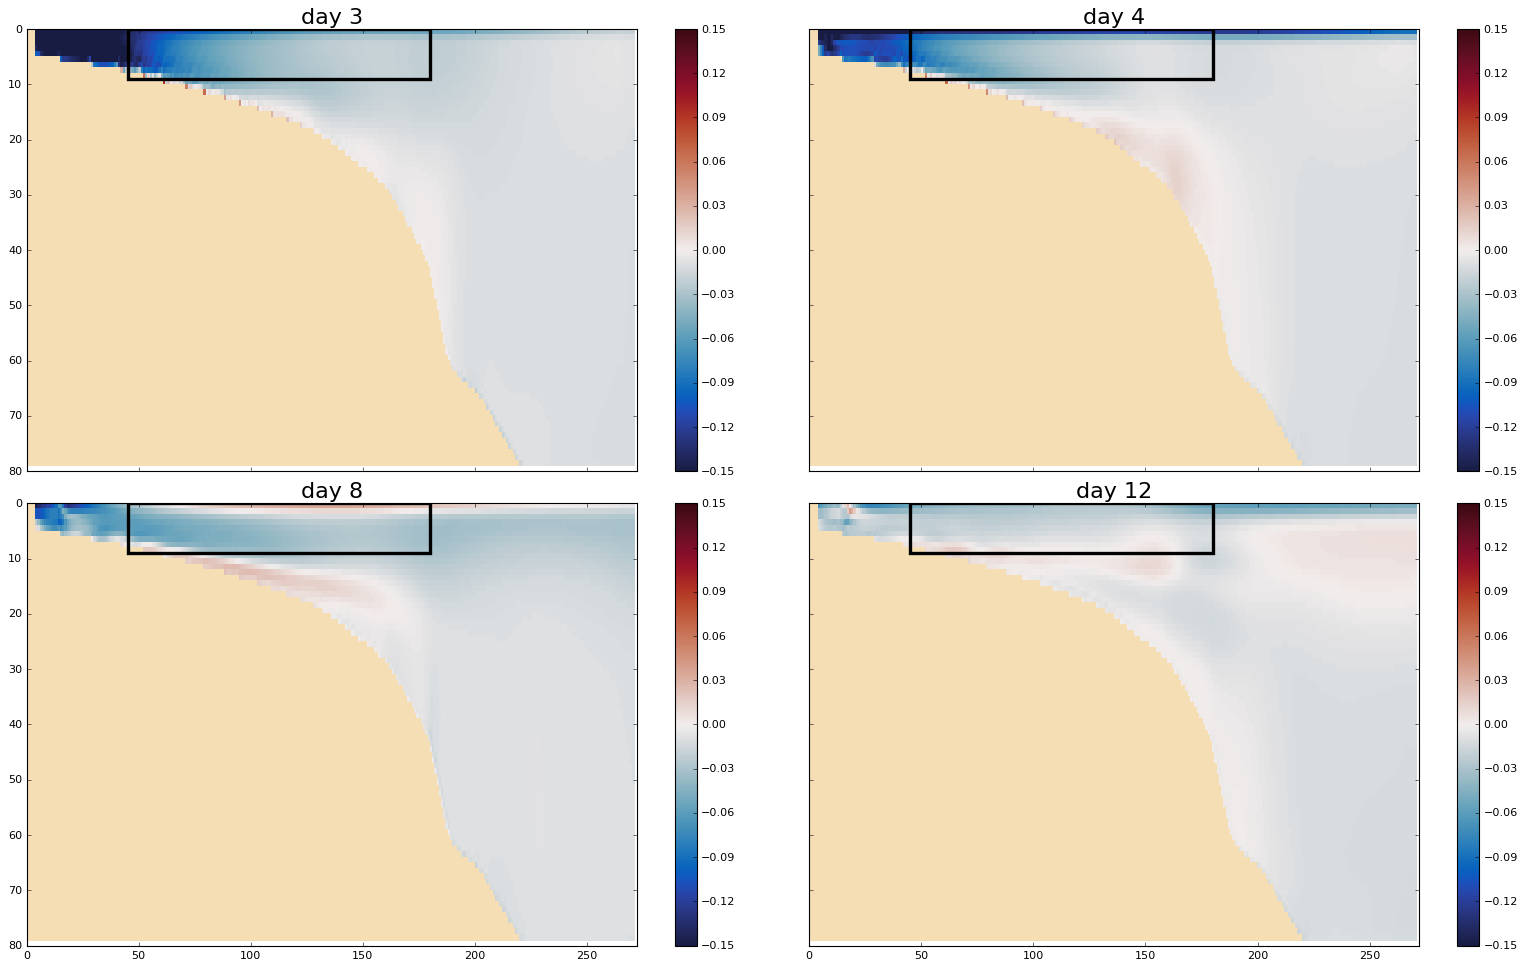

In [110]:
fig = plot_crossU(x_start, vozocrtx_day3, vozocrtx_day4, vozocrtx_day8, vozocrtx_day15)

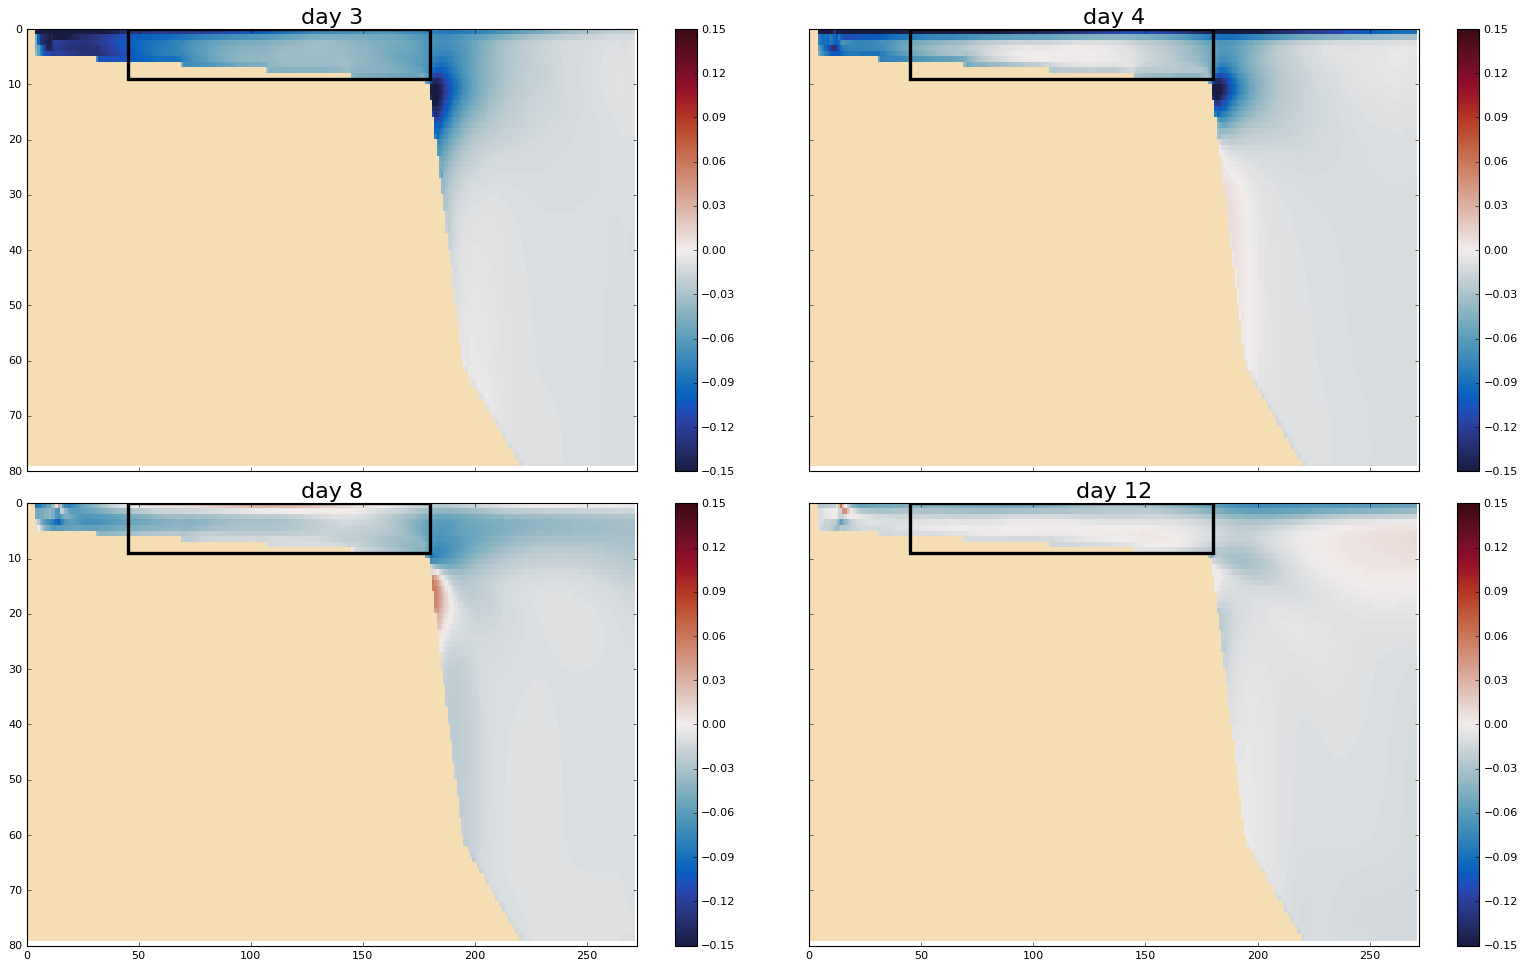

In [111]:
fig = plot_crossU(x_end, vozocrtx_day3, vozocrtx_day4, vozocrtx_day8, vozocrtx_day15)

## Top profiles of U

In [96]:
def plot_topU(dep_ind, vozocrtx_day3, vozocrtx_day4, vozocrtx_day8, vozocrtx_day12):
    fig, axes = plt.subplots(2,2,figsize=(20, 12), sharex=True, sharey=True)
    fig.tight_layout(h_pad=2, w_pad=0.2)
    cmap = plt.get_cmap(cmo.cm.balance)
    cmap.set_bad('wheat')
    vels = [vozocrtx_day3, vozocrtx_day4, vozocrtx_day8, vozocrtx_day12]
    ttls = ['day 3', 'day 4', 'day 8', 'day 12']
    for ax, vel, ttl, n in zip(axes.flatten(), vels, ttls, np.arange(4)):
        p = ax.pcolormesh(xs, ys, vel[dep_ind, :, :], cmap=cmap, vmin=-0.2, vmax=0.2)
        ax.set_xlim([0, vel.shape[-1]])
        ax.set_ylim([0, vel.shape[-2]])
        ax.add_patch(patches.Rectangle((x_start, y_start),x_end-x_start,y_end-y_start, fill=False, linewidth=3))
        fig.colorbar(p, ax=ax)
        ax.set_title(ttl+' (dep_ind ' + str(dep_ind)+': '+str(int(depthu[dep_ind]))+'m)', fontsize=20)
    return fig

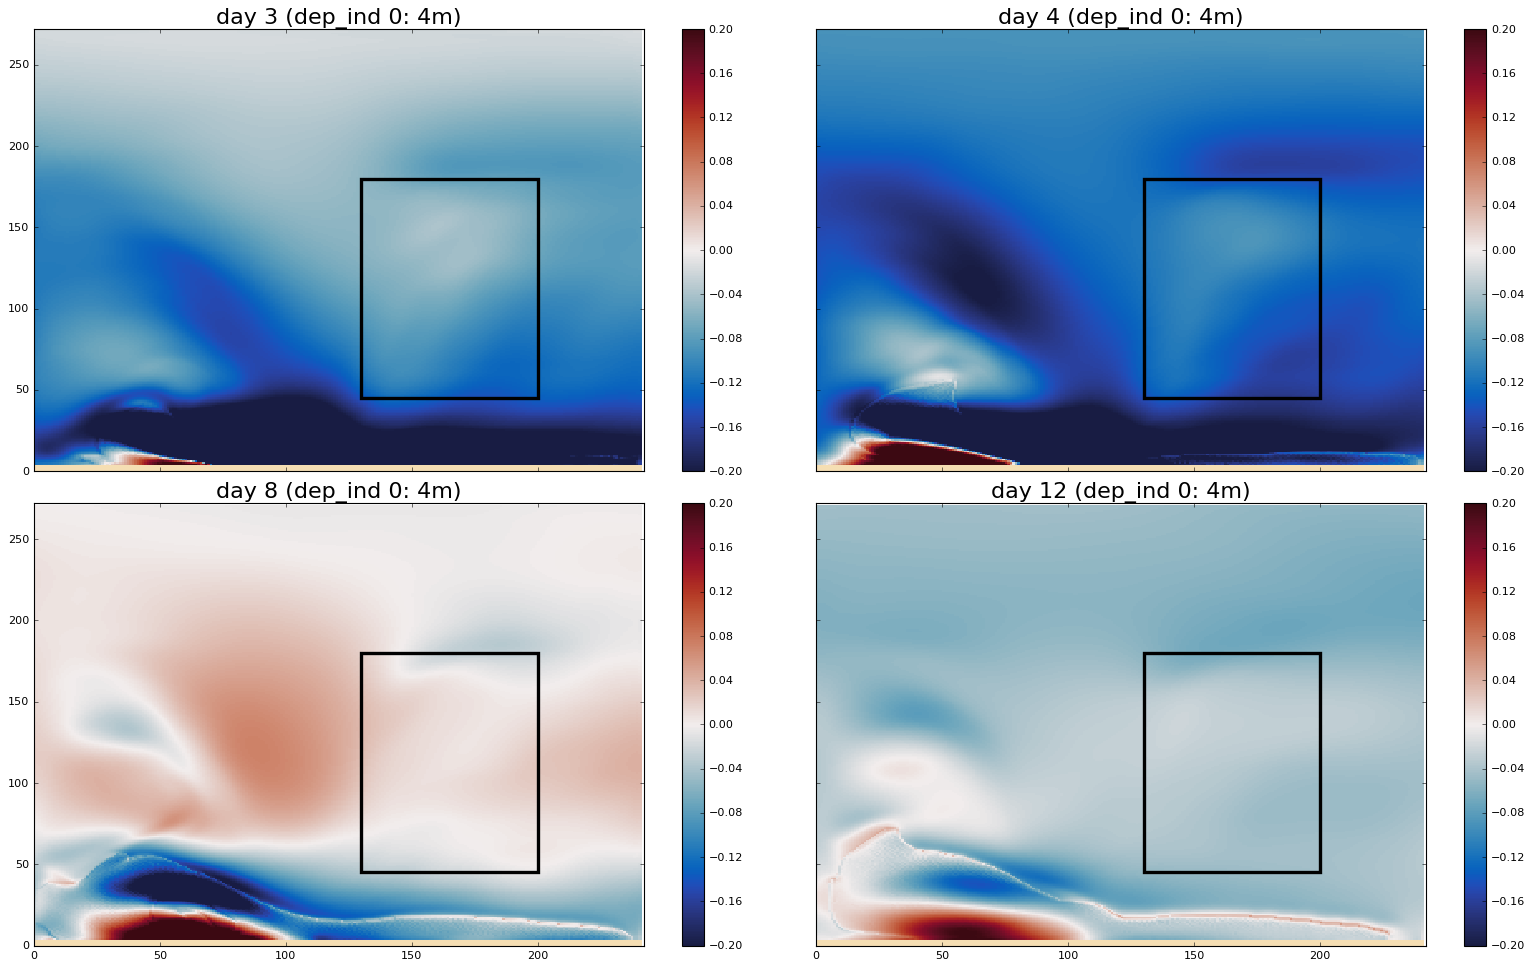

In [97]:
dep_ind = dep_ind0
fig = plot_topU(dep_ind, vozocrtx_day3, vozocrtx_day4, vozocrtx_day8, vozocrtx_day15)

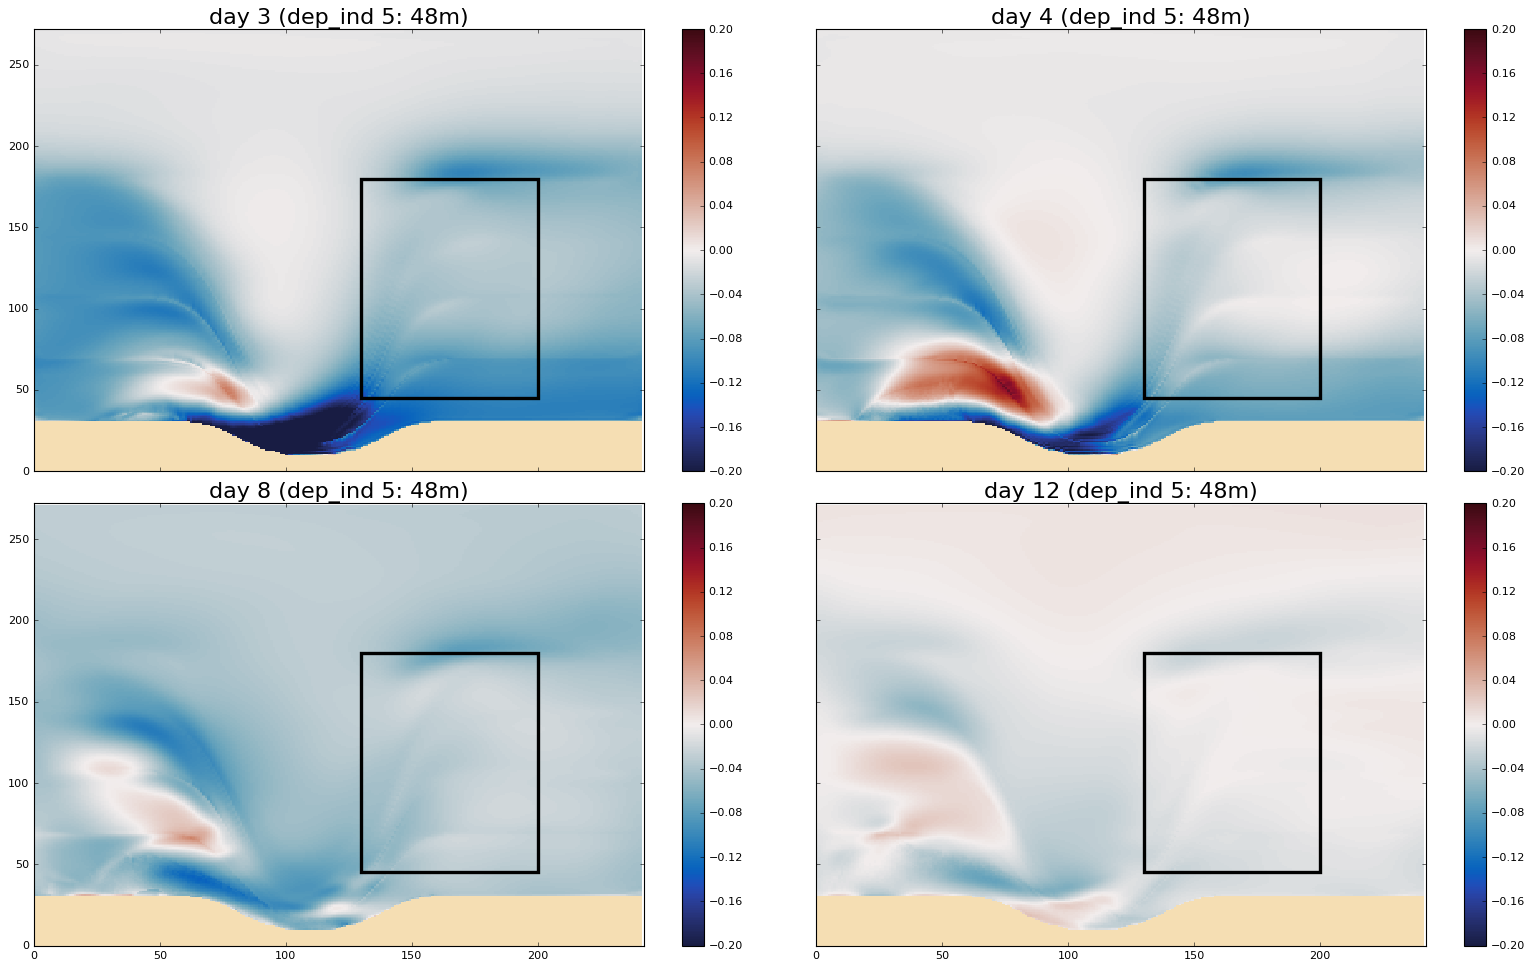

In [98]:
dep_ind = dep_ind1
fig = plot_topU(dep_ind, vozocrtx_day3, vozocrtx_day4, vozocrtx_day8, vozocrtx_day15)

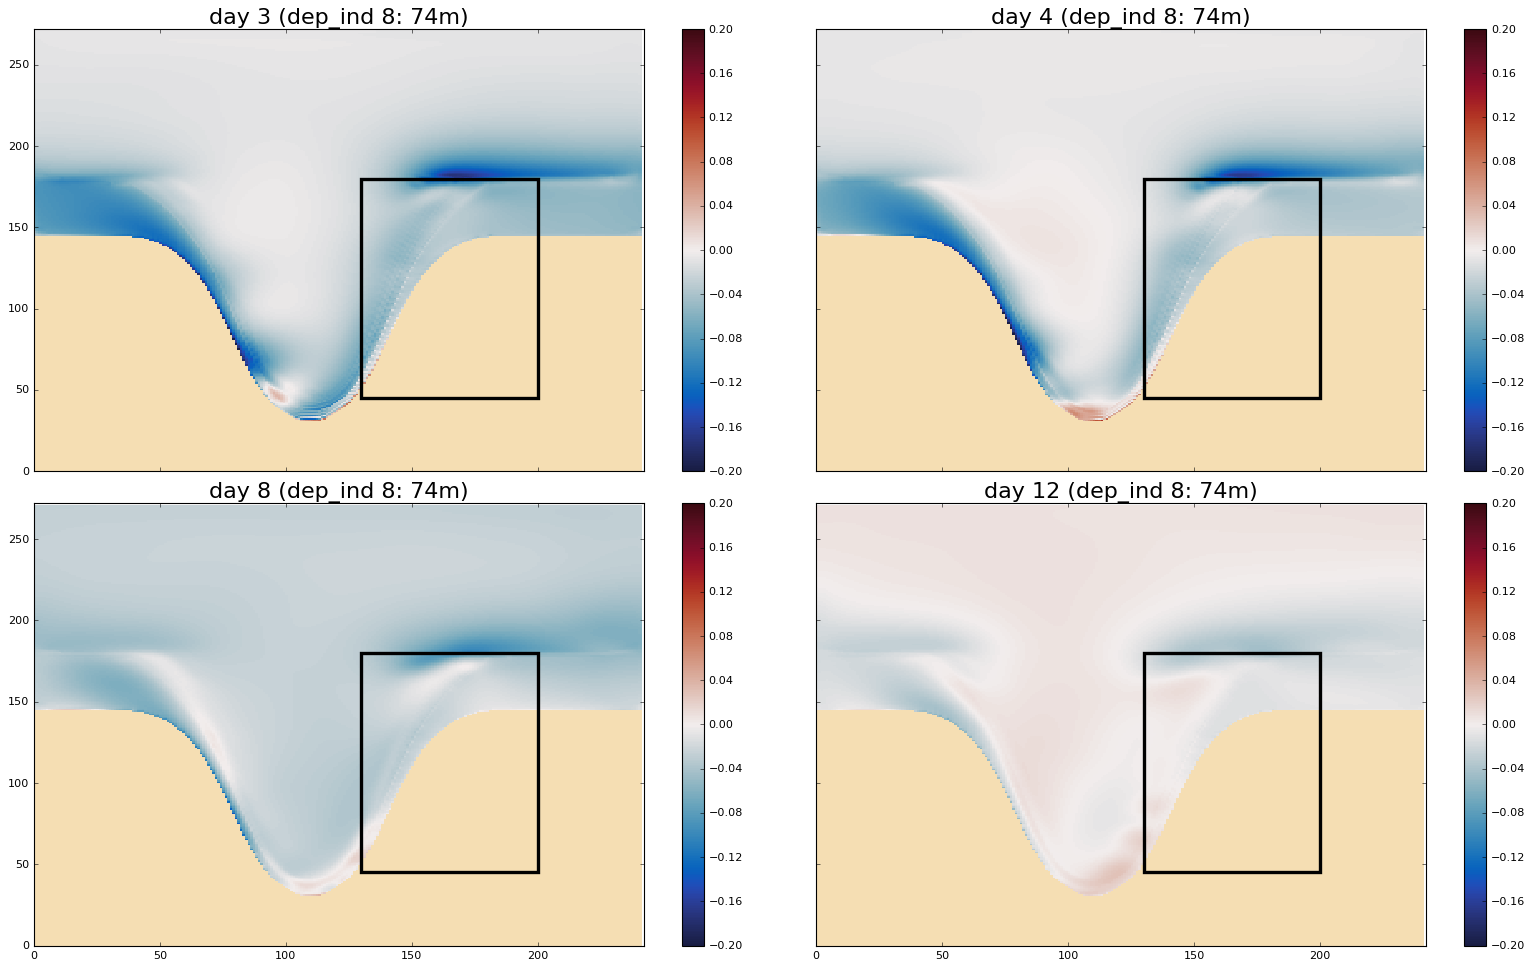

In [99]:
dep_ind = dep_ind2
fig = plot_topU(dep_ind, vozocrtx_day3, vozocrtx_day4, vozocrtx_day8, vozocrtx_day15)

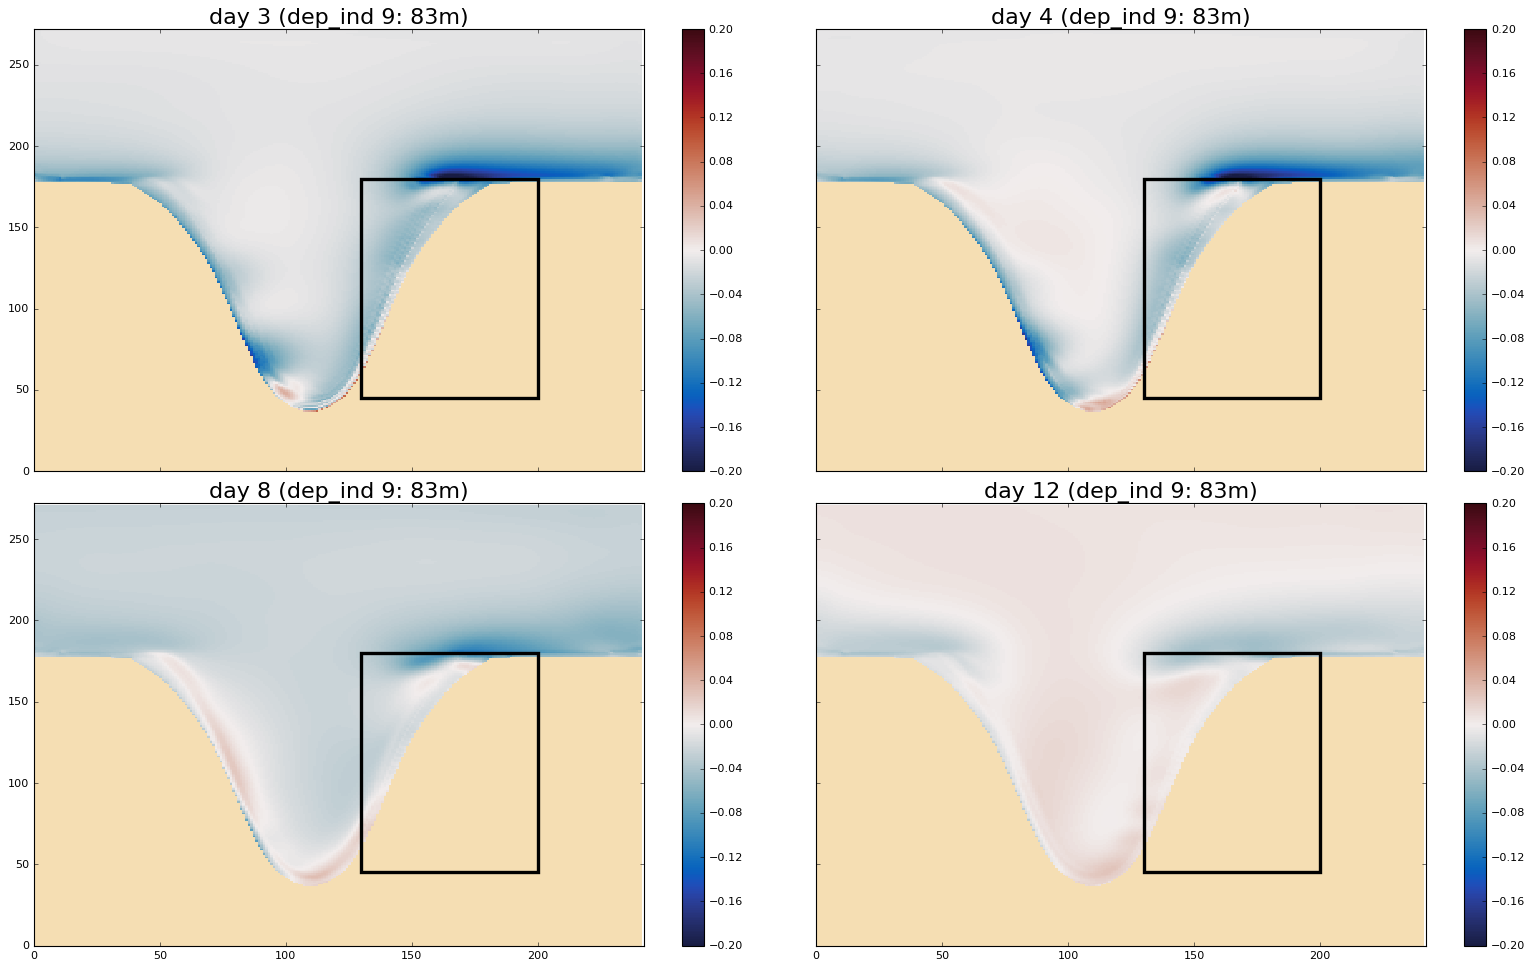

In [100]:
dep_ind = dep_ind3
fig = plot_topU(dep_ind, vozocrtx_day3, vozocrtx_day4, vozocrtx_day8, vozocrtx_day15)

## Closer look at depths

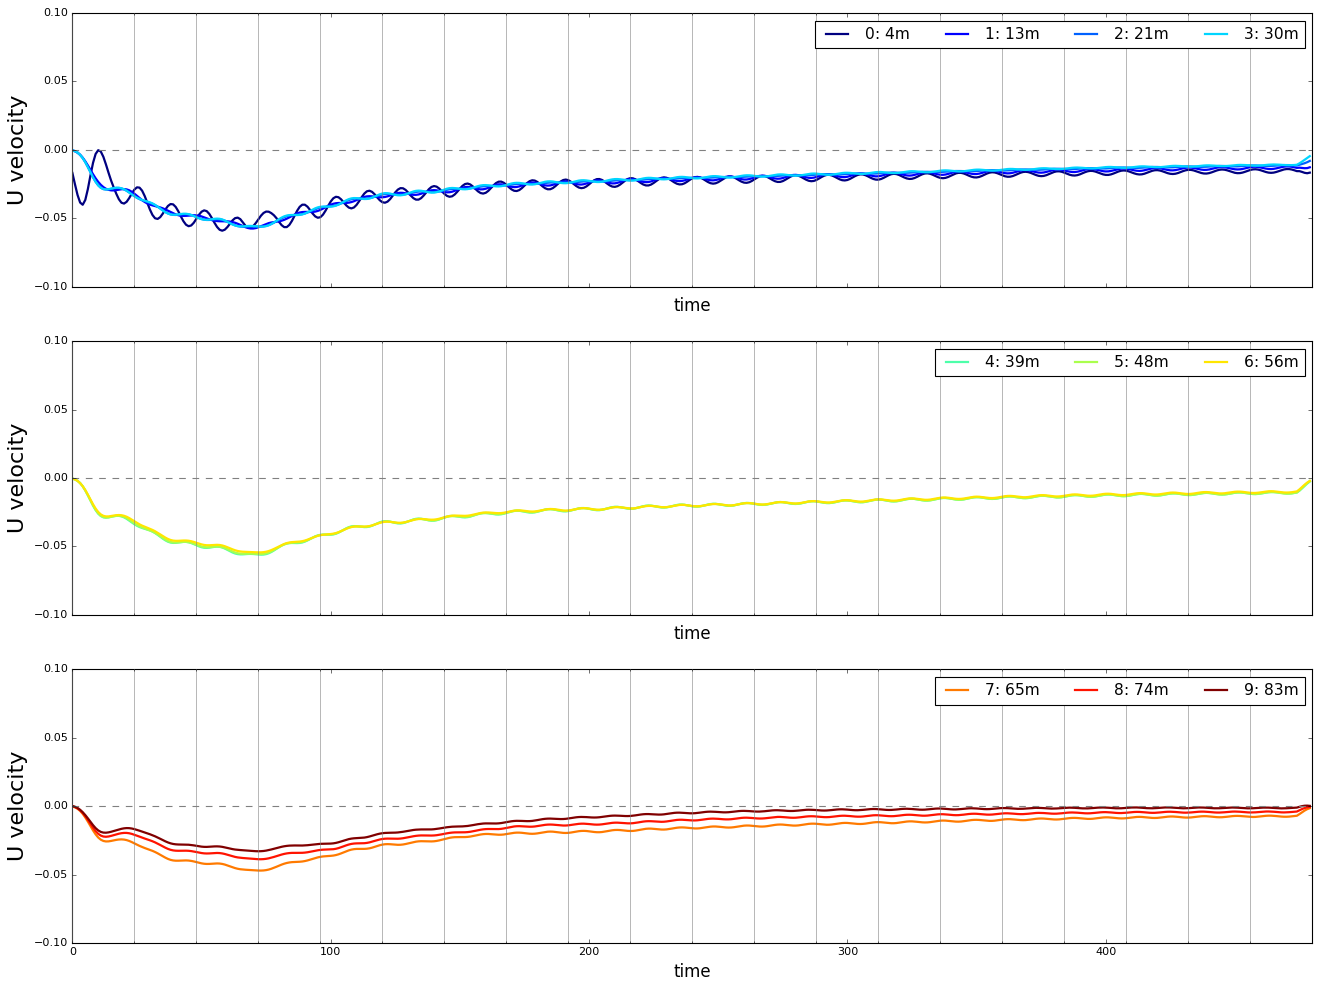

In [103]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(20, 15), sharex=True)

cm_times = np.linspace(0, 1, 10)
colors = [cm.jet(x) for x in cm_times]

for dep_ind in range(4):
    U = general_functions.smooth(avgU[:, dep_ind], 12)
    ax1.plot(U, c=colors[dep_ind], label=str(dep_ind)+': '+str(int(depthu[dep_ind]))+'m', lw=2)

for dep_ind in range(4, 7):
    U = general_functions.smooth(avgU[:, dep_ind], 12)
    ax2.plot(U, c=colors[dep_ind], label=str(dep_ind)+': '+str(int(depthu[dep_ind]))+'m', lw=2)

for dep_ind in range(7, 10):
    U = general_functions.smooth(avgU[:, dep_ind], 12)
    ax3.plot(U, c=colors[dep_ind], label=str(dep_ind)+': '+str(int(depthu[dep_ind]))+'m', lw=2)

for ax, n in zip([ax1, ax2, ax3], np.arange(3)):
    ax.set_xlabel('time', fontsize=15)
    ax.set_ylabel('U velocity', fontsize=20)
    ax.set_xlim([0, 480])
    ax.set_ylim([-0.1, 0.1])
    ml = MultipleLocator(24)
    ax.xaxis.set_minor_locator(ml)
    ax.xaxis.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
    ax.legend(ncol=9, fontsize=14)
    ax.axhline(0, linestyle='--', c='gray')